# Feature Selection Experiments for openSMILE

The [openSMILE Python API](https://audeering.github.io/opensmile-python/) includes the [ComParE 2016](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set which enables us to extract 65 low-level descriptors (for ex. MFCC) as well as 6373 Functionals derived from these decriptors. 

For each audio file - the LLDs are a `samples x 65` df and the functionals are a `1 x 6373` df. 

In these experiments, we extract the functionals for both real and fake audio data and run a set of feature selection techniques to identify a hnadful subset of features for use in a final predictive model.

## Import Statements

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

## Data Loading and Summary

To save time, the data is sampled and features are extracted using openSMILE in a separate notebook `sampling_and_mixing_data.ipynb` and saved in `.csv` format for reusability. The dataset used contains original audio from the [LJSpeech 1.1](https://keithito.com/LJ-Speech-Dataset/) dataset and fake audio generated using GANs for the [NeurIPS 2021 WaveFake](https://arxiv.org/abs/2111.02813) dataset. It also contains audio from LJSpeech generated using ElevenLabs.

Contains 12,800 audio files - 6400 each real and fake with a set of 800 real audio files matching a set of the same 800 fakes generated using one of the archs listed below. 

In [2]:
exp_data_file = '/home/ubuntu/testing-code/opensmile-feature-importance/smile_dfs/0310-lj_experimental_data_v1.csv'
exp_data_df = pd.read_csv(exp_data_file)

In [3]:
exp_data_df.head()

,id,file,type,fake,duration(seconds),audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,LJ032-0137,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,7.762,2.529597,0.608866,0.765319,0.343702,0.589645,...,10.773912,0.657822,2.936347,2.935397,20.000000,0.609994,129.240130,64.158455,130.97571,60.847908
1,LJ038-0165,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,8.656,2.406416,0.005841,0.695093,0.295922,0.514596,...,8.458103,0.531263,2.910538,2.911863,-20.000000,0.650057,125.028530,58.838596,115.42761,55.276188
2,LJ044-0203,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,5.150,2.695161,0.249012,0.175889,0.375376,0.674925,...,11.555664,0.663116,2.731076,2.731820,-20.000000,0.479881,126.260170,54.306473,109.07703,62.240750
3,LJ003-0044,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,3.199,2.287197,0.528846,0.996795,0.478625,0.801715,...,11.162925,0.497092,3.827386,3.820832,19.997963,0.526514,155.382830,77.223274,146.11166,88.627940
4,LJ036-0116,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,2.340,2.027513,0.181416,0.513274,0.277241,0.572403,...,6.160469,0.462080,2.797420,2.774368,19.579084,0.638266,99.164055,44.689617,123.44574,49.456890


In [4]:
exp_data_df.shape

(12800, 6378)

In [5]:
exp_data_df.type.value_counts()

ElevenLabs           1600
Waveglow             1600
Parallel_WaveGan     1600
Multi_Band_MelGan    1600
MelGanLarge          1600
MelGan               1600
HifiGan              1600
Full_Band_MelGan     1600
Name: type, dtype: int64

In [6]:
#check to ensure each id has a corresponding fake
exp_data_df.id.value_counts()

LJ032-0137    2
LJ038-0118    2
LJ046-0168    2
LJ016-0171    2
LJ037-0020    2
             ..
LJ004-0171    2
LJ042-0184    2
LJ015-0150    2
LJ007-0172    2
LJ028-0069    2
Name: id, Length: 6400, dtype: int64

## Train-Dev-Test Split:

In [7]:
#split the data 
f1 = 0.8
f2 = 0.9
train_df, dev_df, test_df = np.split(exp_data_df.sample(frac=1), [int(f1*len(exp_data_df)), int(f2*len(exp_data_df))])

In [8]:
#check split
len(train_df), len(dev_df), len(test_df), (len(train_df) + len(dev_df) + len(test_df))

(10240, 1280, 1280, 12800)

In [9]:
train_df.type.value_counts()

Parallel_WaveGan     1307
MelGanLarge          1287
Multi_Band_MelGan    1285
Waveglow             1284
Full_Band_MelGan     1280
MelGan               1270
HifiGan              1266
ElevenLabs           1261
Name: type, dtype: int64

In [10]:
dev_df.type.value_counts()

MelGan               175
MelGanLarge          174
Full_Band_MelGan     164
ElevenLabs           163
HifiGan              159
Waveglow             158
Parallel_WaveGan     145
Multi_Band_MelGan    142
Name: type, dtype: int64

In [11]:
test_df.type.value_counts()

ElevenLabs           176
HifiGan              175
Multi_Band_MelGan    173
Waveglow             158
Full_Band_MelGan     156
MelGan               155
Parallel_WaveGan     148
MelGanLarge          139
Name: type, dtype: int64

## Feature Scaling:

In [12]:
exp_data_scaler = StandardScaler()
train_df.iloc[:,5:] = exp_data_scaler.fit_transform(train_df.iloc[:,5:])
dev_df.iloc[:,5:] = exp_data_scaler.transform(dev_df.iloc[:,5:])
test_df.iloc[:,5:] = exp_data_scaler.transform(test_df.iloc[:,5:])

## Experiment 1: Brute Force Feature Selection

In the first experiment, we break down the data set into each architecture used to generate fakes 

In [13]:
def run_bflr_for_arch(train_df, dev_df, arch, all_archs=False):
    
    #prepare data
    if all_archs==False:
        trdf = train_df[train_df.type==arch]
    if all_archs==True:
        trdf = train_df[train_df.type.isin(arch)]
    
    if all_archs==False:
        dvdf = dev_df[dev_df.type==arch]
    if all_archs==True:
        dvdf = dev_df[dev_df.type.isin(arch)]
    
    X_train = trdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_train = trdf['fake'].copy()
    
    X_dev = dvdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
    y_dev = dvdf['fake'].copy()
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [14]:
archs = list(exp_data_df.type.unique())
features = train_df.columns.to_list()[5:]
bruteforce_df = pd.DataFrame(features, columns=['features'])

for arch in archs:
    print("\nRunning for {} architecture\n".format(arch))
    bruteforce_df[arch] = run_bflr_for_arch(train_df, dev_df, arch)

print("\nRunning for all architectures\n")
bruteforce_df['all_archs'] = run_bflr_for_arch(train_df, dev_df, archs, all_archs=True)


Running for ElevenLabs architecture



100%|██████████| 6373/6373 [00:36<00:00, 175.88it/s]



Average train accuracy: 0.6236740720573125
Average dev accuracy: 0.6257148880582287


Running for Waveglow architecture



100%|██████████| 6373/6373 [00:46<00:00, 137.29it/s]



Average train accuracy: 0.5300982581793421
Average dev accuracy: 0.5228982237167481


Running for Parallel_WaveGan architecture



100%|██████████| 6373/6373 [00:44<00:00, 142.89it/s]



Average train accuracy: 0.5271592774173659
Average dev accuracy: 0.5234702435382026


Running for Multi_Band_MelGan architecture



100%|██████████| 6373/6373 [00:33<00:00, 187.57it/s]



Average train accuracy: 0.5256801401339918
Average dev accuracy: 0.499321521471525


Running for MelGanLarge architecture



100%|██████████| 6373/6373 [00:45<00:00, 141.23it/s]



Average train accuracy: 0.5288211448575485
Average dev accuracy: 0.4940319342917589


Running for MelGan architecture



100%|██████████| 6373/6373 [00:40<00:00, 155.78it/s]



Average train accuracy: 0.5256939030432274
Average dev accuracy: 0.5159409114343997


Running for HifiGan architecture



100%|██████████| 6373/6373 [00:55<00:00, 114.20it/s]



Average train accuracy: 0.515880954133862
Average dev accuracy: 0.5085961115436881


Running for Full_Band_MelGan architecture



100%|██████████| 6373/6373 [00:46<00:00, 138.01it/s]



Average train accuracy: 0.513786187823631
Average dev accuracy: 0.5093228674323461


Running for all architectures



100%|██████████| 6373/6373 [03:32<00:00, 29.97it/s]


Average train accuracy: 0.5170776462958968
Average dev accuracy: 0.5181506698179822



In [15]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1250,pcm_fftMag_spectralFlux_sma_percentile99.0,0.687117,0.569620,0.744828,0.661972,0.620690,0.600000,0.654088,0.591463,0.571094
1251,pcm_fftMag_spectralFlux_sma_pctlrange0-1,0.687117,0.569620,0.744828,0.661972,0.620690,0.600000,0.654088,0.591463,0.571875
3737,jitterLocal_sma_flatness,0.687117,0.670886,0.600000,0.690141,0.574713,0.708571,0.635220,0.603659,0.605469
3776,jitterDDP_sma_flatness,0.662577,0.721519,0.737931,0.795775,0.614943,0.771429,0.767296,0.707317,0.676562


In [16]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
3776,jitterDDP_sma_flatness,0.662577,0.721519,0.737931,0.795775,0.614943,0.771429,0.767296,0.707317,0.676562


In [17]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1250,pcm_fftMag_spectralFlux_sma_percentile99.0,0.687117,0.569620,0.744828,0.661972,0.620690,0.600000,0.654088,0.591463,0.571094
1251,pcm_fftMag_spectralFlux_sma_pctlrange0-1,0.687117,0.569620,0.744828,0.661972,0.620690,0.600000,0.654088,0.591463,0.571875
1730,mfcc_sma[7]_lpgain,0.546012,0.569620,0.606897,0.605634,0.839080,0.777143,0.566038,0.554878,0.607812
1930,mfcc_sma[14]_iqr1-3,0.779141,0.556962,0.586207,0.598592,0.574713,0.645714,0.584906,0.560976,0.548438
3737,jitterLocal_sma_flatness,0.687117,0.670886,0.600000,0.690141,0.574713,0.708571,0.635220,0.603659,0.605469
3757,jitterLocal_sma_percentile1.0,0.509202,0.753165,0.689655,0.816901,0.649425,0.788571,0.704403,0.652439,0.693750
3776,jitterDDP_sma_flatness,0.662577,0.721519,0.737931,0.795775,0.614943,0.771429,0.767296,0.707317,0.676562
3790,jitterDDP_sma_quartile1,0.496933,0.841772,0.765517,0.915493,0.620690,0.834286,0.842767,0.664634,0.728906
3796,jitterDDP_sma_percentile1.0,0.527607,0.854430,0.710345,0.845070,0.574713,0.805714,0.767296,0.695122,0.729688


In [18]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1701,mfcc_sma[6]_lpc1,0.742331,0.588608,0.524138,0.542254,0.931034,0.920000,0.547170,0.603659,0.648438
1763,mfcc_sma[8]_lpc1,0.588957,0.481013,0.441379,0.556338,0.896552,0.908571,0.547170,0.615854,0.616406
1793,mfcc_sma[9]_lpc0,0.760736,0.500000,0.482759,0.500000,0.913793,0.925714,0.515723,0.573171,0.618750
1794,mfcc_sma[9]_lpc1,0.613497,0.582278,0.468966,0.528169,0.919540,0.914286,0.559748,0.560976,0.602344
1825,mfcc_sma[10]_lpc1,0.631902,0.531646,0.462069,0.521127,0.885057,0.902857,0.566038,0.579268,0.621875
1885,mfcc_sma[12]_lpgain,0.797546,0.613924,0.579310,0.669014,0.908046,0.874286,0.572327,0.426829,0.596875
1887,mfcc_sma[12]_lpc1,0.668712,0.569620,0.551724,0.500000,0.908046,0.948571,0.490566,0.579268,0.605469
1917,mfcc_sma[13]_lpc0,0.680982,0.601266,0.641379,0.591549,0.856322,0.914286,0.446541,0.530488,0.560937
1918,mfcc_sma[13]_lpc1,0.564417,0.493671,0.544828,0.500000,0.890805,0.937143,0.515723,0.579268,0.592969
1948,mfcc_sma[14]_lpc0,0.791411,0.544304,0.572414,0.542254,0.844828,0.920000,0.446541,0.585366,0.607031


In [19]:
bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1436,pcm_fftMag_spectralSlope_sma_percentile99.0,0.969325,0.506329,0.710345,0.598592,0.557471,0.594286,0.559748,0.640244,0.605469
1576,mfcc_sma[2]_lpc0,0.779141,0.556962,0.537931,0.542254,0.666667,0.674286,0.484277,0.573171,0.601562
1577,mfcc_sma[2]_lpc1,0.674847,0.601266,0.565517,0.584507,0.747126,0.731429,0.503145,0.573171,0.610938
1669,mfcc_sma[5]_lpc0,0.883436,0.525316,0.482759,0.542254,0.844828,0.765714,0.553459,0.609756,0.603125
1670,mfcc_sma[5]_lpc1,0.803681,0.531646,0.468966,0.492958,0.885057,0.851429,0.610063,0.573171,0.628906
1699,mfcc_sma[6]_lpgain,0.588957,0.569620,0.613793,0.464789,0.833333,0.760000,0.496855,0.560976,0.605469
1700,mfcc_sma[6]_lpc0,0.865031,0.537975,0.537931,0.492958,0.873563,0.862857,0.534591,0.603659,0.633594
1701,mfcc_sma[6]_lpc1,0.742331,0.588608,0.524138,0.542254,0.931034,0.920000,0.547170,0.603659,0.648438
1730,mfcc_sma[7]_lpgain,0.546012,0.569620,0.606897,0.605634,0.839080,0.777143,0.566038,0.554878,0.607812
1731,mfcc_sma[7]_lpc0,0.901840,0.531646,0.572414,0.436620,0.821839,0.857143,0.509434,0.451220,0.644531


In [20]:
max_idxs = []
for arch in archs + ['all_archs']:
    max_idxs.append(bruteforce_df[arch].idxmax())
bruteforce_df[bruteforce_df.index.isin(max_idxs)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
93,pcm_zcr_sma_range,1.000000,0.481013,0.551724,0.514085,0.591954,0.502857,0.528302,0.493902,0.571875
1701,mfcc_sma[6]_lpc1,0.742331,0.588608,0.524138,0.542254,0.931034,0.920000,0.547170,0.603659,0.648438
1887,mfcc_sma[12]_lpc1,0.668712,0.569620,0.551724,0.500000,0.908046,0.948571,0.490566,0.579268,0.605469
3776,jitterDDP_sma_flatness,0.662577,0.721519,0.737931,0.795775,0.614943,0.771429,0.767296,0.707317,0.676562
3790,jitterDDP_sma_quartile1,0.496933,0.841772,0.765517,0.915493,0.620690,0.834286,0.842767,0.664634,0.728906
3796,jitterDDP_sma_percentile1.0,0.527607,0.854430,0.710345,0.845070,0.574713,0.805714,0.767296,0.695122,0.729688


In [21]:
feats_lr_1 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)].features.to_list()
feats_lr_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)].features.to_list()
feats_lr_3 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)].features.to_list()
feats_lr_4 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)].features.to_list()
feats_lr_5 = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].features.to_list()
feats_lr_6 = bruteforce_df[bruteforce_df.index.isin(max_idxs)].features.to_list()

exp_1_feature_set = set().union(feats_lr_1, feats_lr_2, feats_lr_3, feats_lr_4, feats_lr_5, feats_lr_6)

In [22]:
selected_features = list(exp_1_feature_set)

In [23]:
exp_1_feature_set

{'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_flatness',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[12]_lpc1',
 'mfcc_sma[12]_lpgain',
 'mfcc_sma[13]_lpc0',
 'mfcc_sma[13]_lpc1',
 'mfcc_sma[14]_iqr1-3',
 'mfcc_sma[14]_lpc0',
 'mfcc_sma[14]_lpc1',
 'mfcc_sma[2]_lpc0',
 'mfcc_sma[2]_lpc1',
 'mfcc_sma[5]_lpc0',
 'mfcc_sma[5]_lpc1',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[6]_lpgain',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[7]_lpgain',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[10]_lpc2',
 'mfcc_sma_de[12]_lpc1',
 'mfcc_sma_de[12]_lpgain',
 'mfcc_sma_de[13]_lpc1',
 'mfcc_sma_de[13]_lpc2',
 'mfcc_sma_de[13]_lpc3',
 'mfcc_sma_de[14]_lpc1',
 'mfcc_sma_de[14]_lpgain',
 'mfcc_sma_de[2]_lpc0',
 'mfcc_sma_de[2]_lpc1',
 'mfcc_sma_

In [24]:
len(exp_1_feature_set)

72

#### Test on held out test data

In [25]:
df_lr_final = pd.concat([train_df, dev_df])
X_train_lr_final = df_lr_final.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train_lr_final = df_lr_final['fake'].copy()

X_test_lr_final = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_test_lr_final = test_df['fake'].copy()

In [26]:
#select features identified from brute force
feature_index = train_df.columns.intersection(selected_features)

#fit model
model_lr_final = LogisticRegression(max_iter=1000)
model_lr_final.fit(X_train_lr_final[feature_index], y_train_lr_final)

#predict on held out test data
yhat_train_final = model_lr_final.predict(X_train_lr_final[feature_index])
yhat_test_final = model_lr_final.predict(X_test_lr_final[feature_index])

#compute accuracy
accuracy_lr_train = accuracy_score(y_train_lr_final, yhat_train_final)
accuracy_lr_test = accuracy_score(y_test_lr_final, yhat_test_final)

#print
print('Logistic accuracy train = %.3f' % (accuracy_lr_train*100))
print('Logistic accuracy test = %.3f' % (accuracy_lr_test*100))

Logistic accuracy train = 91.406
Logistic accuracy test = 92.031


## SQS testing

In [27]:
X_train = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train = train_df['fake'].copy()

X_dev = dev_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_dev = dev_df['fake'].copy()

X_test = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_test = test_df['fake'].copy()

In [33]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

In [37]:
cv = StratifiedKFold(5)
visualizer = RFECV(LogisticRegression(max_iter=1000), step=50, cv=cv, scoring='f1_weighted')

KeyboardInterrupt: 

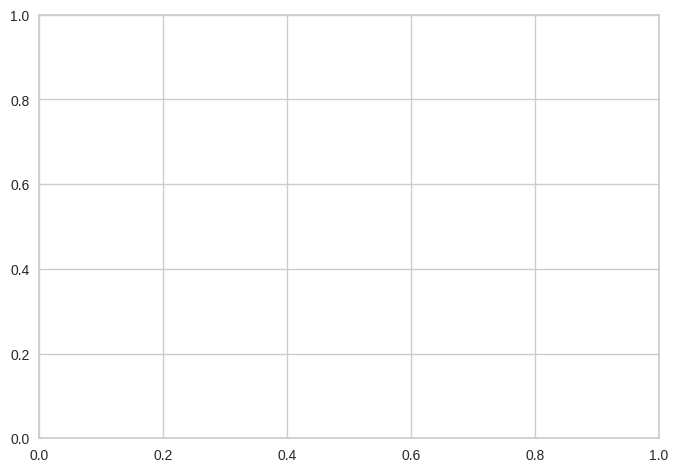

In [38]:
visualizer.fit(X_train, y_train)
visualizer.show()